Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
!pip install --upgrade google-cloud-storage

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import storage
project_id = 'sincere-hearth-439414-q5'
client = storage.Client(project=project_id)

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
bucket_name = "cancer_cell_detection"
file_name = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
destination_path = '/content/train/'

if not os.path.exists(destination_path):
  os.makedirs(destination_path)

#bucket = bucket.list_blobs(prefix=source_folder)
bucket = client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=file_name)
for blob in blobs:
  relative_path = blob.name[len(file_name):]
  local_file_path = os.path.join(destination_path, relative_path)
  local_dir = os.path.dirname(local_file_path)
  if not os.path.exists(local_dir):
    os.makedirs(local_dir)

  blob.download_to_filename(local_file_path)
  print(f"Downlaoded {blob.name} to {local_file_path}")

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/train/")
#data_dir_test = pathlib.Path('path_to_test_directory')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
# image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
# print(image_count_test)

2239


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/train',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split= 0.2,
    subset = "training",

)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/train/',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.2,
    subset = "validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

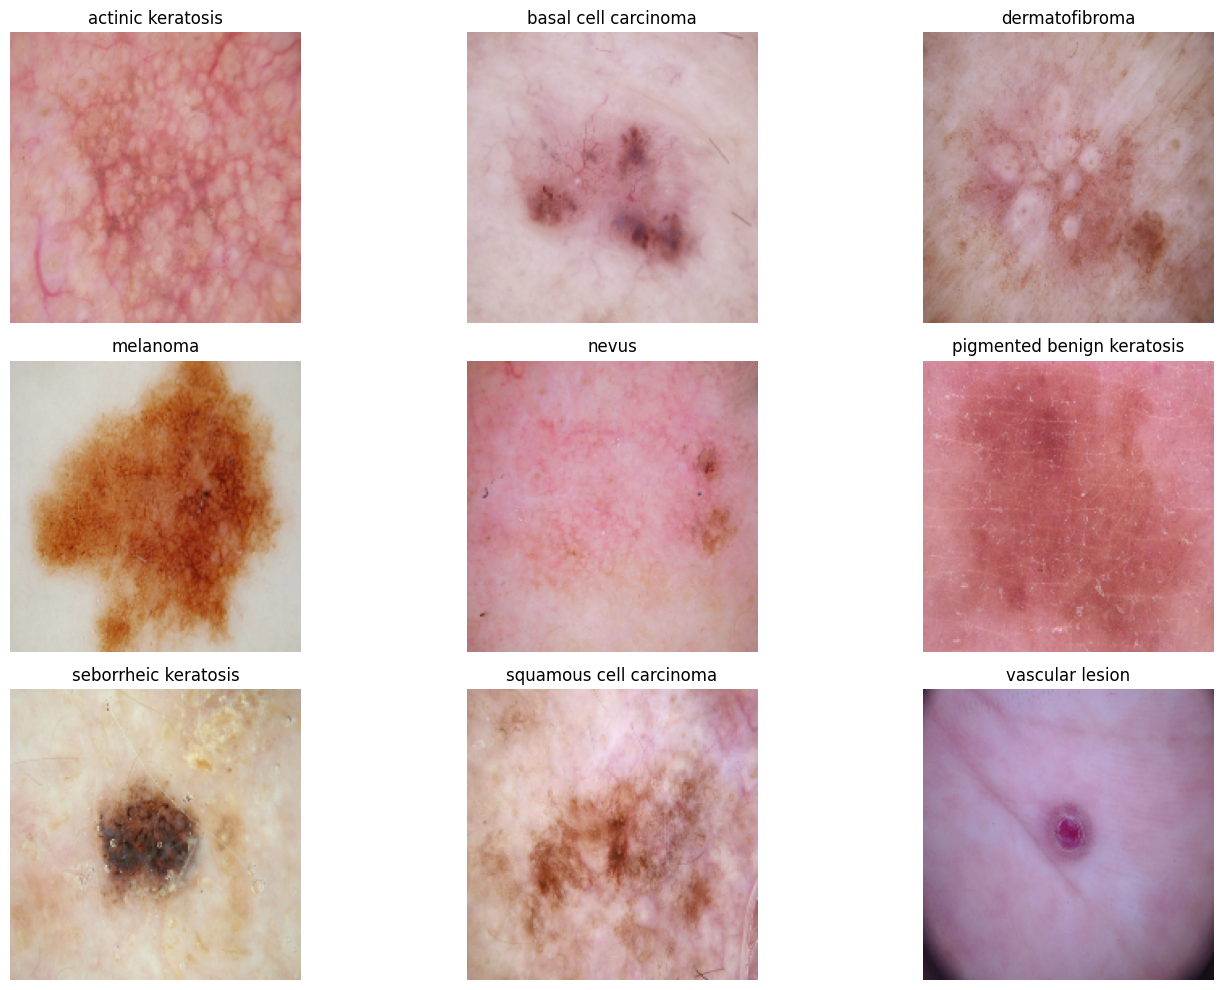

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
num_classes = len(class_names)
dict_image = {name: None for name in class_names}
for images, labels in train_ds:
  for one_image, one_labels in zip(images, labels):
    cls_name = class_names[one_labels]
    if dict_image[cls_name] is None:
      dict_image[cls_name] = one_image
    if all( v is not None for v in dict_image.values()):
      break
  if all( v is not None for v in dict_image.values()):
    break
  plt.figure(figsize=(15,10))
for i, class_name in enumerate(class_names):
  plt.subplot(3,3, i+1)
  plt.imshow(dict_image[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")

plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch.shape)
  print(label_batch)

(32, 180, 180, 3)
tf.Tensor([8 4 5 5 3 2 5 0 1 5 7 4 0 4 7 3 3 5 1 5 3 1 1 1 0 1 5 4 2 7 4 1], shape=(32,), dtype=int32)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
def convert_labels(img, labels):
  labels = tf.where(labels == 3,1,0)
  return img, labels



In [ ]:
train_ds_binary = train_ds.map(convert_labels)
val_ds_binary = val_ds.map(convert_labels)

In [ ]:
### Your code goes here
from tensorflow.keras import models
input_shape = (180, 180, 3)
num_classes = 2
model = models.Sequential()
model.add(layers.Rescaling(1./180, input_shape=input_shape))

model.add(layers.Convolution2D(filters=32, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.Convolution2D(filters=32, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.Convolution2D(filters=32, kernel_size=(5,5), strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=1))

model.add(layers.Convolution2D(filters=64, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.Convolution2D(filters=64, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.Convolution2D(filters=64, kernel_size=(5,5), strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=1))

model.add(layers.Convolution2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.Convolution2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.Convolution2D(filters=128, kernel_size=(5,5), strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=1))

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=3, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))



# return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 176, 176, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 86, 86, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 82, 82, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 80, 80, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 38, 38, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │           1,539 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 892,427 (3.40 MB)

 Trainable params: 892,427 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds_binary,
  validation_data=val_ds_binary,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.7064 - loss: 0.6895 - val_accuracy: 0.8076 - val_loss: 0.6772
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.7908 - loss: 0.6742 - val_accuracy: 0.8076 - val_loss: 0.6618
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8216 - loss: 0.6566 - val_accuracy: 0.8076 - val_loss: 0.6476
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8186 - loss: 0.6424 - val_accuracy: 0.8076 - val_loss: 0.6344
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.7907 - loss: 0.6352 - val_accuracy: 0.8076 - val_loss: 0.6226
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.7931 - loss: 0.6235 - val_accuracy: 0.8076 - val_loss: 0.6111
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.8040 - loss: 0.6094 - val_accuracy: 0.8076 - val_loss: 0.6003
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.8106 - loss: 0.5969 - val_accuracy: 0.807

### Visualizing training results

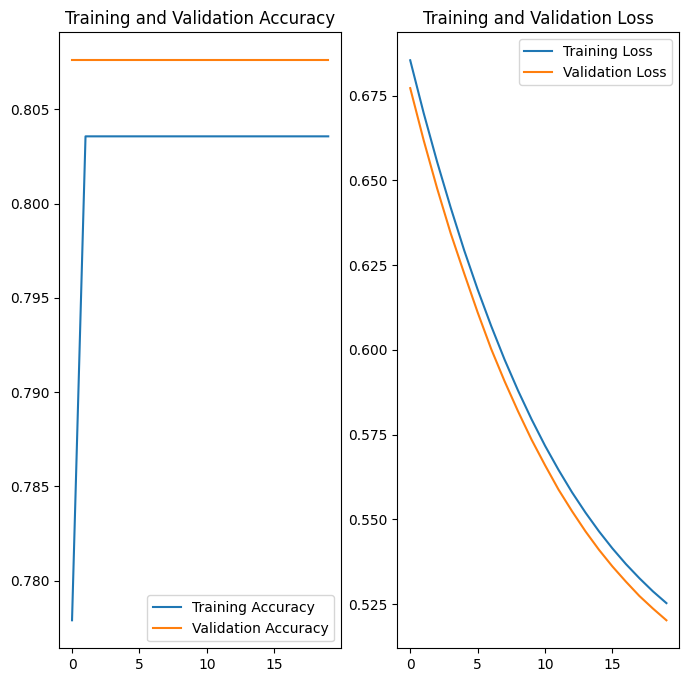

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

1. The model clearly is underfitting as it it not able to improve the accuracy on training dat after certian iterations
2. For testing data to it did not perform well enough

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_height, img_width = 180, 180
batch_size = 32

dataaug = ImageDataGenerator(
    width_shift_range = 1.0,
    rotation_range = 180,
    zoom_range = 0.1,
    rescale = 1.0/180,
    horizontal_flip = True,
    validation_split = 0.2
)

#input_size = (244,244)


train_gen = dataaug.flow_from_directory(
    directory='/content/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = 'training',
    shuffle = True,
    seed = 123
)

val_gen = dataaug.flow_from_directory(
    directory='/content/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset ='validation',
    shuffle = True,
    seed = 123,
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [ ]:
def convert_labels_gen(img, labels):
  labels = tf.where(labels[:, 3] == 1,1,0)
  return img, labels


In [ ]:
def custom_generator(generator):
    for img, labels in generator:
        img, labels = convert_labels_gen(img, labels)  # Apply the conversion function
        yield img, labels

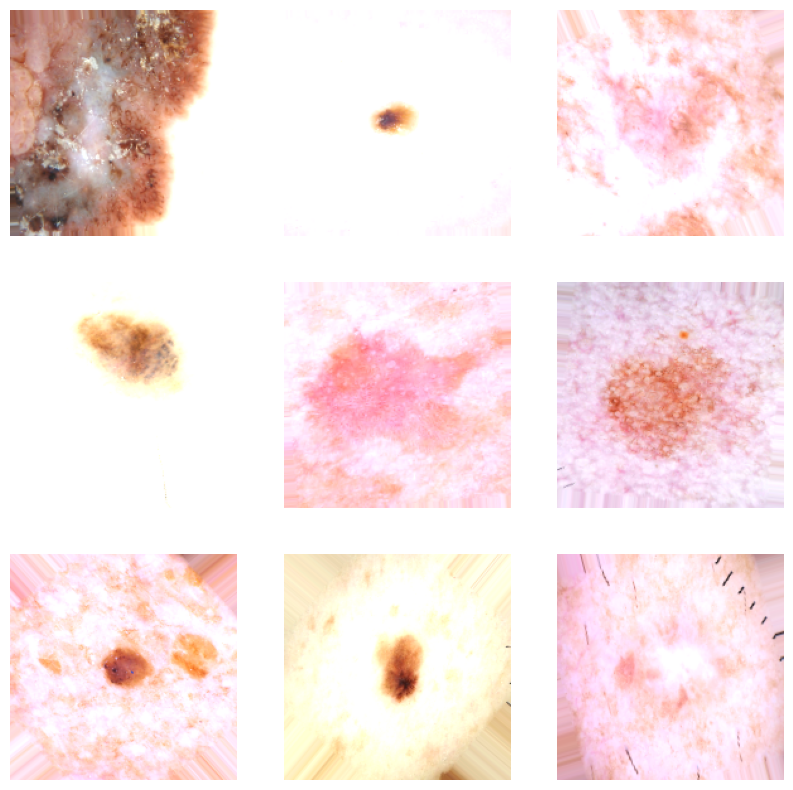

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
images, labels = next(train_gen)

# Plot first 9 images in the batch
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(images[i]))
    plt.axis('off')
plt.show()

### Todo:
### Create the model, compile and train the model


In [ ]:
from tensorflow.keras import layers, models

input_shape = (180, 180, 3)
num_classes = 2

model = models.Sequential()

# Input Scaling Layer
model.add(layers.Rescaling(1./255, input_shape=input_shape))  # Changed scaling to 1./255

# Convolutional Block 1
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.Conv2D(filters=32, kernel_size=(5,5), strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=1))
model.add(layers.Dropout(0.3))  # Dropout layer

# Convolutional Block 2
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.Conv2D(filters=64, kernel_size=(5,5), strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=1))
model.add(layers.Dropout(0.3))  # Dropout layer

# Convolutional Block 3
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.Conv2D(filters=128, kernel_size=(5,5), strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=1))
model.add(layers.Dropout(0.4))  # Dropout layer

# Global Average Pooling
model.add(layers.GlobalAveragePooling2D())

# Dense Layers for Binary Classification
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout layer
model.add(layers.Dense(units=1, activation='sigmoid'))  # Changed to single unit for binary classification

# Model Summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 176, 176, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 176, 176, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 86, 86, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 82, 82, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 82, 82, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 80, 80, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 80, 80, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 38, 38, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             5

 Total params: 893,185 (3.41 MB)

 Trainable params: 892,289 (3.40 MB)

 Non-trainable params: 896 (3.50 KB)

### Compiling the model

In [ ]:
## Your code goes here

model.compile(optimizer='adam',
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
# Assuming train_gen and val_gen are iterable objects with a known length
# Use len(train_gen) and len(val_gen) to get the number of batches if possible

epochs = 20
steps_per_epoch = len(train_gen)  # or the number of batches for training per epoch
validation_steps = len(val_gen)   # or the number of batches for validation per epoch

history = model.fit(
    custom_generator(train_gen),
    steps_per_epoch=steps_per_epoch,
    validation_data=custom_generator(val_gen),
    validation_steps=validation_steps,
    epochs=epochs,
    verbose=1
)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 615s 11s/step - accuracy: 0.7542 - loss: 0.6473 - val_accuracy: 0.8041 - val_loss: 0.5062
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 608s 11s/step - accuracy: 0.8106 - loss: 0.4548 - val_accuracy: 0.2027 - val_loss: 1.1141
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 607s 11s/step - accuracy: 0.8206 - loss: 0.3537 - val_accuracy: 0.8198 - val_loss: 0.5141
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 606s 11s/step - accuracy: 0.8184 - loss: 0.3686 - val_accuracy: 0.7973 - val_loss: 0.6836
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 615s 11s/step - accuracy: 0.8503 - loss: 0.3396 - val_accuracy: 0.8063 - val_loss: 1.0447
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 610s 11s/step - accuracy: 0.8397 - loss: 0.3655 - val_accuracy: 0.7995 - val_loss: 0.8413
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 615s 11s/step - accuracy: 0.8370 - loss: 0.3550 - val_accuracy: 0.1937 - val_loss: 2.5484
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 612s 11s/step - accuracy: 0.8588 - loss: 0.3569 - val_accuracy: 0.

### Visualizing the results

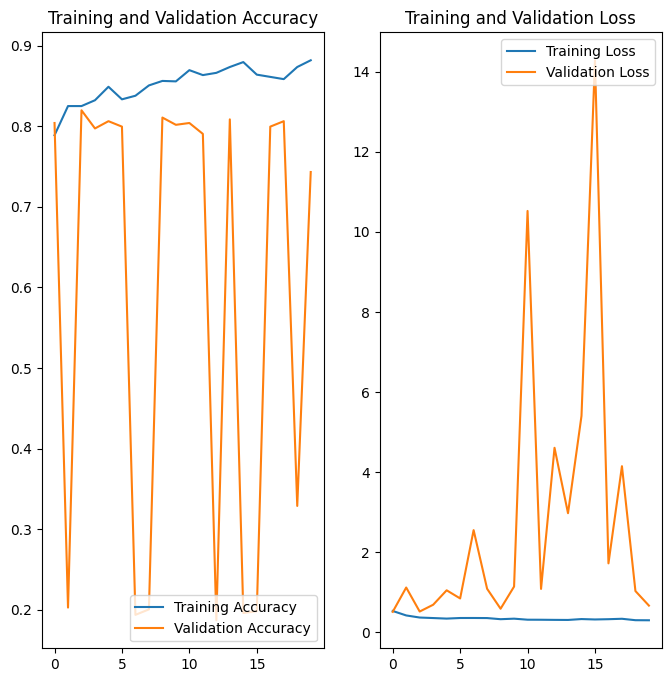

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1. Clearly the model is not working well with validation task the prominent reason been overfitting

2. Atleast we were able to handle underfitting by augmenting the current dataset
3. The validation accuracy needs to be satbalized for that we will try balancing the classes further

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
class_names = train_ds_aug.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
path_to_training_dataset="/content/train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5B219DB340>: 100%|██████████| 500/500 [00:17<00:00, 28.70 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5B21998FD0>: 100%|██████████| 500/500 [00:15<00:00, 31.70 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5B21560850>: 100%|██████████| 500/500 [00:15<00:00, 31.30 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E5B2188CF10>: 100%|██████████| 500/500 [01:17<00:00,  6.46 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7E5B2197B190>: 100%|██████████| 500/500 [01:11<00:00,  6.96 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E5B21AD2320>: 100%|██████████| 500/500 [00:15<00:00, 32.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E5B1BF25CC0>: 100%|██████████| 500/500 [00:38<00:00, 12.90 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5B218C4A90>: 100%|██████████| 500/500 [00:16<00:00, 30.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5BA95FD600>: 100%|██████████| 500/500 [00:16<00:00, 30.50 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
from pathlib import Path

data_dir_train = Path('/content/train/')
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
data_dir_train = str(data_dir_train)
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
dataframe_dict_new

In [ ]:
original_image_paths = []
original_labels = []
data_dir_train = Path(data_dir_train)
# Assuming each subfolder in data_dir_train represents a label
for label_dir in data_dir_train.glob('*'):
    if label_dir.is_dir():
        # Add all original images in each label directory
        original_images = list(label_dir.glob('*.jpg'))
        original_image_paths.extend(original_images)
        original_labels.extend([label_dir.name] * len(original_images))

# Create DataFrame for original images
original_df = pd.DataFrame({
    'Path': [str(img) for img in original_image_paths],
    'Label': original_labels
})


In [ ]:
original_df

,Path,Label
0,/content/train/dermatofibroma/ISIC_0030321.jpg,dermatofibroma
1,/content/train/dermatofibroma/ISIC_0031799.jpg,dermatofibroma
2,/content/train/dermatofibroma/ISIC_0033847.jpg,dermatofibroma
3,/content/train/dermatofibroma/ISIC_0029052.jpg,dermatofibroma
4,/content/train/dermatofibroma/ISIC_0030757.jpg,dermatofibroma
...,...,...
2234,/content/train/actinic keratosis/ISIC_0032422.jpg,actinic keratosis
2235,/content/train/actinic keratosis/ISIC_0032199.jpg,actinic keratosis
2236,/content/train/actinic keratosis/ISIC_0033494.jpg,actinic keratosis
2237,/content/train/actinic keratosis/ISIC_0027536.jpg,actinic keratosis


In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/train/"
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
def convert_labels_gen(img, labels):
  labels = tf.where(labels[:] == 1,1,0)
  return img, labels

In [ ]:
train_ds_aug = train_ds_aug.map(convert_labels_gen)

In [ ]:
val_ds_aug = val_ds_aug.map(convert_labels_gen)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
from tensorflow.keras import layers, models, regularizers

input_shape = (180, 180, 3)
num_classes = 2

model = models.Sequential()

# Input Scaling Layer
model.add(layers.Rescaling(1./180, input_shape=input_shape))  # Changed scaling to 1./255

# Convolutional Block 1
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.Conv2D(filters=32, kernel_size=(5,5), strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=1))
model.add(layers.Dropout(0.3))  # Dropout layer

# Convolutional Block 2
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.Conv2D(filters=64, kernel_size=(5,5), strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=1))
model.add(layers.Dropout(0.3))  # Dropout layer

# Convolutional Block 3
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.Conv2D(filters=128, kernel_size=(5,5), strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=1))
model.add(layers.Dropout(0.4))  # Dropout layer

# Global Average Pooling
model.add(layers.GlobalAveragePooling2D())

# Dense Layers for Binary Classification
model.add(layers.Dense(units=512, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))  # Dropout layer
model.add(layers.Dense(units=1, activation='sigmoid'))  # Changed to single unit for binary classification

# Model Summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 176, 176, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 176, 176, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 86, 86, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 82, 82, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 82, 82, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 80, 80, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 80, 80, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 38, 38, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 32, 32, 128)         │             5

 Total params: 893,185 (3.41 MB)

 Trainable params: 892,289 (3.40 MB)

 Non-trainable params: 896 (3.50 KB)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer= 'adam',
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
import os
import shutil
train_dir = "/content/train/"
for labels in os.listdir(train_dir):
    label_path = os.path.join(train_dir, labels)
    # print(label_path)
    if os.path.isdir(label_path):
      output_folder = os.path.join(label_path, 'output')
      if os.path.exists(output_folder):
        for file_name in os.listdir(output_folder):
          file_path =  os.path.join(output_folder, file_name)
          shutil.move(file_path, label_path)
        os.rmdir(output_folder)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
# steps_per_epoch = len(train_gen)  # or the number of batches for training per epoch
# validation_steps = len(val_gen)   # or the number of batches for validation per epoch

history = model.fit(
    train_ds,
    #steps_per_epoch=steps_per_epoch,
    validation_data= val_ds,
    # validation_steps=validation_steps,
    epochs=epochs,
    verbose=1
)


Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - accuracy: 0.8268 - loss: 0.6753 - val_accuracy: 0.8849 - val_loss: 0.5489
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - accuracy: 0.8299 - loss: 0.5885 - val_accuracy: 0.8849 - val_loss: 0.4443
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.8547 - loss: 0.5012 - val_accuracy: 0.8849 - val_loss: 0.5108
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.8518 - loss: 0.4779 - val_accuracy: 0.8196 - val_loss: 0.4335
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.8592 - loss: 0.4388 - val_accuracy: 0.8849 - val_loss: 0.4045
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.8576 - loss: 0.4132 - val_accuracy: 0.8849 - val_loss: 0.3812
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.8600 - loss: 0.3911 - val_accuracy: 0.8872 - val_loss: 0.3722
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.8654 - loss: 0

#### **Todo:**  Visualize the model results

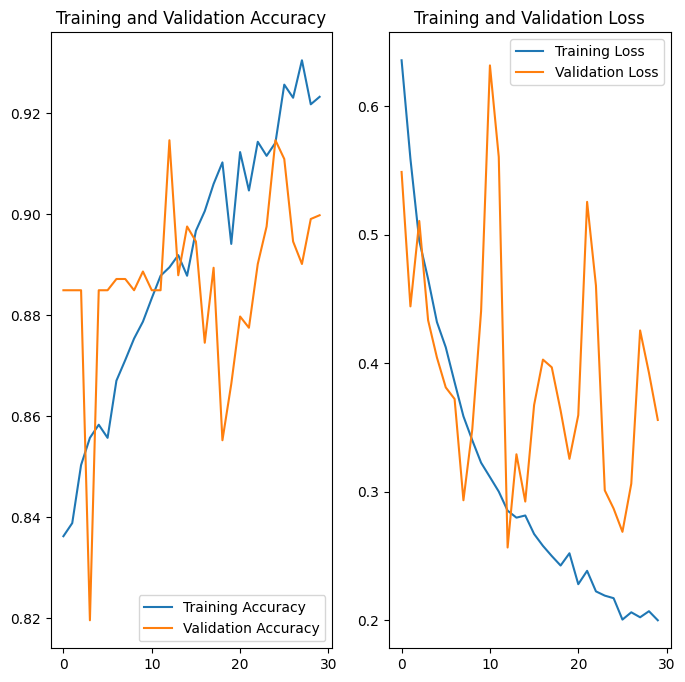

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1. After balancing the class the accuracy of model increased
2. But still the model is failing on validation data
3. Some more processing is required for better result